## 姿态控制器调参

please prepare tacview
请打开tacview软件高级版，点击"记录"-"实时遥测"，并使用以下设置：
IP地址：localhost
端口：42674
Server listening on localhost:42674
Accepted connection from ('127.0.0.1', 6953)
Received data from ('127.0.0.1', 6953): XtraLib.Stream.0
Tacview.RealTimeTelemetry.0
LYH
0 
已建立连接
程序运行时间: 3.51 秒


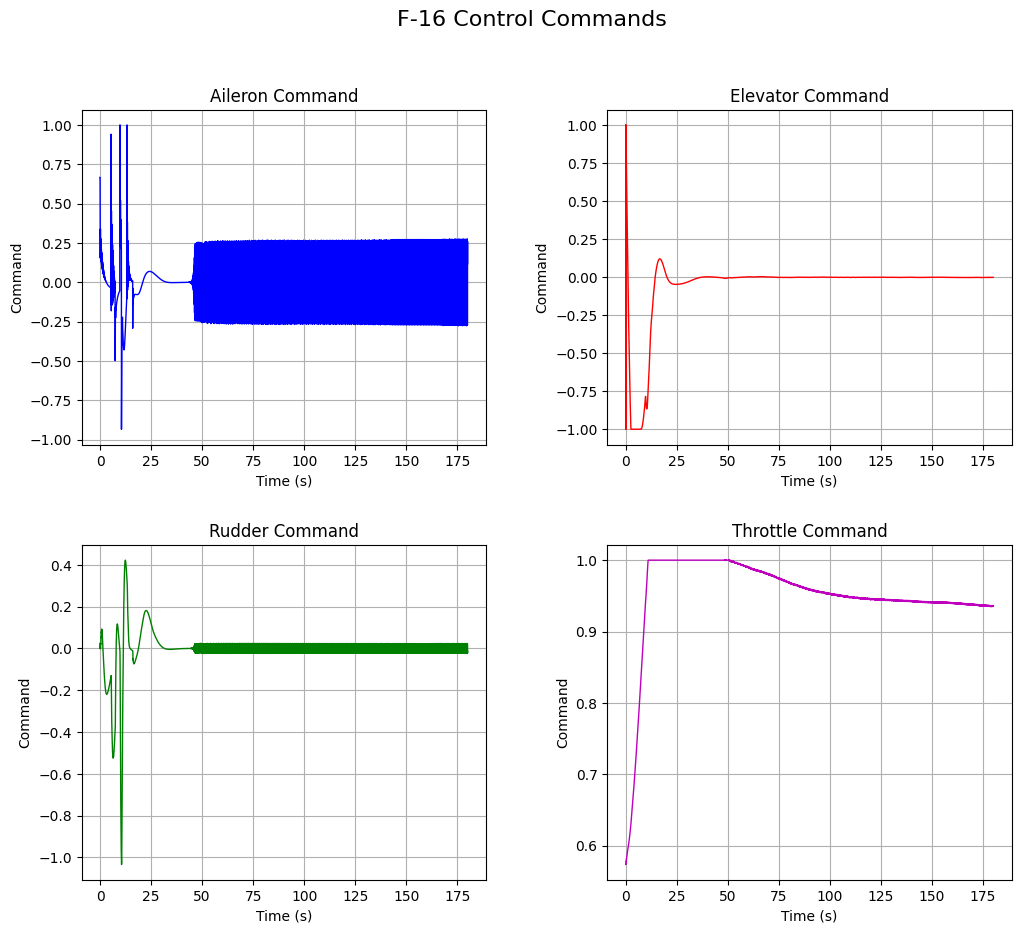

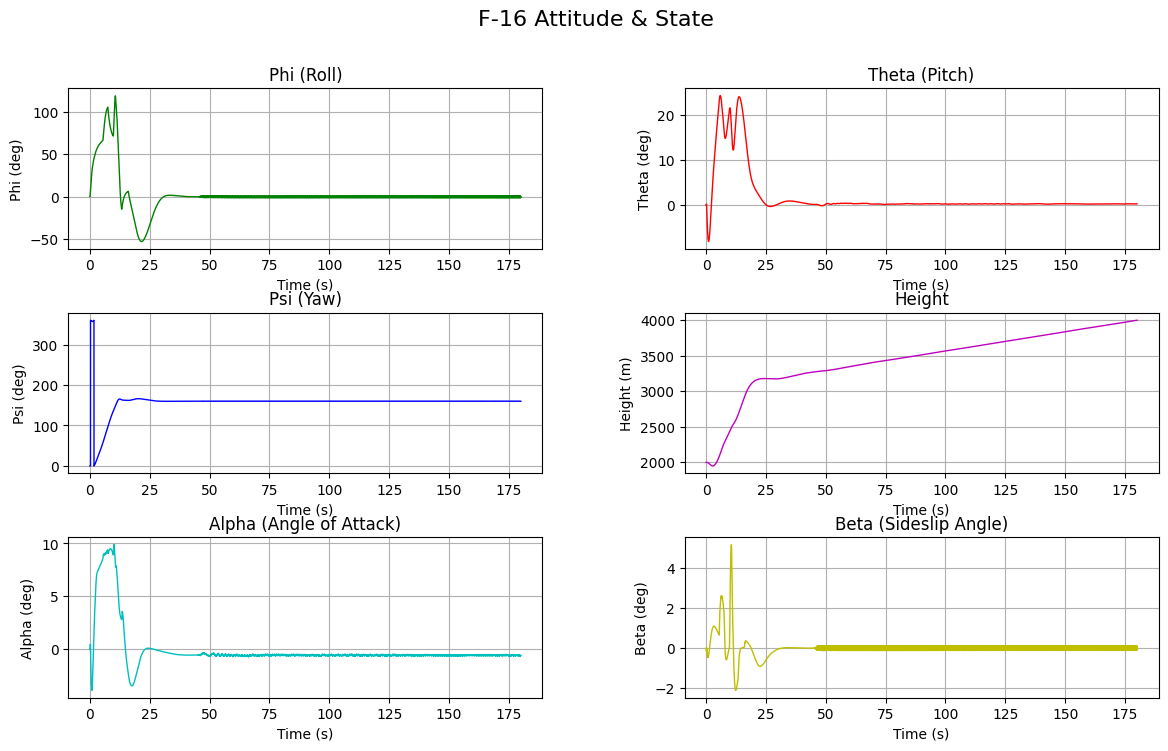

In [1]:
from abc import ABC
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import os
from math import *
from typing import Literal
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import sys
import os
# import matplotlib
# matplotlib.use('Qt5Agg')
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
import socket
import threading
import time
import jsbsim
# import matplotlib.pyplot as plt
import math
import numpy as np
from simple_pid import PID
from numpy.linalg import norm



class DeltaPID(object):
    """增量式PID算法实现"""
    def __init__(self, p=0, i=0, d=0) -> None:
        self.k_p = p  # 比例系数
        self.k_i = i  # 积分系数
        self.k_d = d  # 微分系数
        self._pre_error = 0  # t-1 时刻误差值
        self._pre_pre_error = 0  # t-2 时刻误差值
    def calculate(self, error, dt=0.02):
        p_change = self.k_p * (error - self._pre_error)
        i_change = self.k_i * error * dt
        d_change = self.k_d * (error - 2 * self._pre_error + self._pre_pre_error) / dt
        delta_output = p_change + i_change + d_change  # 本次增量
        self._pre_pre_error = self._pre_error
        self._pre_error = error
        return delta_output

def active_rotation(vector, heading, theta, gamma):
    # vector是行向量，根据psi，theta，gamma的顺序旋转坐标系，最后输出行向量
    # 注意：北天东坐标
    psi = - heading
    R1 = np.array([
        [cos(psi), 0, sin(psi)],
        [0, 1, 0],
        [-sin(psi), 0, cos(psi)]
    ])
    R2 = np.array([
        [cos(theta), -sin(theta), 0],
        [sin(theta), cos(theta), 0],
        [0, 0, 1]
    ])
    R3 = np.array([
        [1, 0, 0],
        [0, cos(gamma), -sin(gamma)],
        [0, sin(gamma), cos(gamma)]
    ])
    return vector @ R1.T @ R2.T @ R3.T

def sub_of_radian(input1, input2):
    # 计算两个弧度的差值，范围为[-pi, pi]
    diff = input1 - input2
    diff = (diff + pi) % (2 * pi) - pi
    return diff

def sub_of_degree(input1, input2):
    # 计算两个角度的差值，范围为[-180, 180]
    diff = input1 - input2
    diff = (diff + 180) % (360) - 180
    return diff

a_last=0
e_last=0
r_last=0
t_last=0.5
last_outputs = [a_last, e_last, r_last, t_last]

tacview_show = 1  # 是否显示Tacview
# 调参 abaaba
yaw_pid = DeltaPID(p=1/pi, i=0.1/pi, d=0/pi) # 平稳飞行航向控制器调参
e_pid = DeltaPID(p=2/pi, i=1/pi, d=0.1/pi) # 升降舵调参
r_pid = DeltaPID(p=5/pi, i=1/pi, d=1/pi) # 方向舵调参
t_pid = PID(1, 0.3, 0.2, setpoint=0) # 油门调参
t_pid.output_limits = (-1, 1)
pids=[yaw_pid, e_pid, r_pid, t_pid]

def attitudeControl(input, last_outputs, pids, dt=0.02):
    yaw_pid, e_pid, r_pid, t_pid = pids
    a_last, e_last, r_last, t_last = last_outputs
    theta_req = input[0]
    delta_heading_req = input[1]
    v_req = input[2]
    theta = input[3]
    v = input[4]
    phi = input[5]
    alpha_air = input[6]
    beta_air = input[7]
    p = input[8]
    q = input[9]
    r = input[10]
    climb_rad = input[11]
    delta_course_rad = input[12]

    # 油门控制
    t_pid.setpoint = v_req
    throttle = 0.5 + 0.5 * t_pid(v, dt)

    # 方向舵控制
    rudder = -beta_air/(5*pi/180)

    # 升降舵控制
    L_ = 1 * np.array(
        [np.cos(theta_req) * np.cos(delta_heading_req), np.sin(theta_req),
         np.cos(theta_req) * np.sin(delta_heading_req)])
    v_ =  1 * np.array(
        [np.cos(climb_rad) * np.cos(delta_course_rad), np.sin(climb_rad),
         np.cos(climb_rad) * np.sin(delta_course_rad)])
    x_b_ = 1 * np.array(
        [np.cos(theta) * np.cos(0), np.sin(theta), np.cos(theta) * np.sin(0)])
    
    # 将期望航向投影到体轴xy平面上，后根据与体轴x夹角设定升降舵量的大小
    y_b_ = active_rotation(np.array([0, 1, 0]), 0, theta, phi)
    z_b_ = active_rotation(np.array([0, 0, 1]), 0, theta, phi)
    L_xy_b_ = L_ - np.dot(L_, z_b_) * z_b_ / norm(z_b_)
    x_b_2L_xy_b_ = np.cross(x_b_, L_xy_b_) / norm(L_xy_b_)  # sin法向差角*z_b_
    x_b_2L_xy_b_sin = np.dot(x_b_2L_xy_b_, z_b_)
    x_b_2L_xy_b_cos = np.dot(x_b_, L_xy_b_) / norm(L_xy_b_)  
    delta_z_angle=np.arctan2(x_b_2L_xy_b_sin, x_b_2L_xy_b_cos)
    # temp = delta_z_angle*180/pi
    # temp = temp

    # alpha = alpha_air*180/pi
    # if -8<alpha/pi<13:
    #     k_alpha_air = 0.3
    # else:
    #     k_alpha_air = 0.9
    # elevetor = e_last+e_pid.calculate(-delta_z_angle*(1-k_alpha_air)+alpha/20*(k_alpha_air), dt=dt)

    elevetor = e_last+e_pid.calculate(-delta_z_angle, dt=dt)
    elevetor=np.clip(elevetor, -1, 1)

    # 副翼战术机动控制
    L_yz_b_ = L_ - np.dot(L_, x_b_) * x_b_ / norm(x_b_)
    
    y_b_2L_yz_b_ = np.cross(y_b_, L_yz_b_) / norm(L_yz_b_)  # sin法向差角*x_b_
    y_b_2L_yz_b_sin = np.dot(y_b_2L_yz_b_, x_b_)
    y_b_2L_yz_b_cos = np.dot(y_b_, L_yz_b_) / norm(L_yz_b_) 

    delta_x_angle=np.arctan2(y_b_2L_yz_b_sin, y_b_2L_yz_b_cos)

    # 特例：abs(delta_x_angle)>5/6*pi 且 delta_z_angle<pi/6时delta_x_angle需要+pi
    if abs(delta_x_angle)>5/6*pi and delta_z_angle<pi/6:
        delta_x_angle=sub_of_radian(delta_x_angle+pi, 0)

    phi_error = delta_x_angle
    aileron = phi_error/pi*6 - p/pi * 4

    # 副翼平稳飞行控制：delta_z_angle**2+delta_x_angle**2足够小时副翼由phi比例控制
    if acos(np.dot(L_, v_)/norm(L_)/norm(v_))*180/pi<20:
    # if abs(delta_x_angle)<2*pi/180 and abs(delta_z_angle)<6/pi:
        
        # phi_req = phi_req +  # yaw_pid.calculate(delta_heading_req, dt=dt)
        k_steady_yaw = 3/20 # 10/20
        phi_req = np.clip(delta_heading_req*180/pi *k_steady_yaw,-1,1) *(pi/3)
        phi_error = phi_req-phi
        aileron = (phi_error/pi*6 -p/pi*4)/3
        # print('steady first')
    # else:
    #     print('rate first')

    aileron=np.clip(aileron, -1, 1)

    norm_act = np.array([aileron, elevetor, rudder, throttle])

    return norm_act


# 高度控制器
def heightcontrol():

    return 0


# if __name__ == '__main__':

# tacview_show = 0  # 是否显示Tacview

dt = 0.02  # 0.02

if tacview_show:
    print('please prepare tacview')
    # sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    from visualize.tacview_visualize import Tacview

    tacview = Tacview()

# 启动 JSBSim
sim = jsbsim.FGFDMExec(None, None)
sim.set_debug_level(0)
sim.set_dt(dt)  # 解算步长 dt 秒

# 设置模型路径（一般 JSBSim pip 包自动包含）
sim.load_model("f16")  # f15, p51d, ball 等模型可选

# 初始姿态与目标姿态
# 连续输出并tacview中可视化
start_time = time.time()
target_theta = 0  # 3000 * 3.2808  # 6000 m to ft
target_heading = 160  # 度 to rad
target_speed = 350  # m/s
t_last = 180.0

# 设置初始状态（单位：英尺、节、角度）
sim["ic/h-sl-ft"] = 2000 * 3.2808  # 高度：m -> ft
sim["ic/vt-kts"] = 300 * 1.9438  # 空速： m/s-> 节
sim["ic/psi-true-deg"] = 0  # 航向角: °
sim["ic/phi-deg"] = 0
sim["ic/theta-deg"] = 0
sim["ic/alpha-deg"] = 0
sim["ic/beta-deg"] = 0
sim["ic/long-gc-deg"] = -118  # 设置初始经度（单位：度）
sim["ic/lat-gc-deg"] = 34  # 设置初始纬度（单位：度）

# 初始化状态
sim.run_ic()
sim.set_property_value('propulsion/set-running', -1)

# 记录轨迹和状态数据
psis = []
thetas = []
phis = []
heights=[]
alphas=[]
betas=[]

thrust_data = []  # 添加推力数据记录
time_steps = []

# 记录控制量
aileron_cmd = []
elevator_cmd = []
rudder_cmd = []
throttle_cmd = []

# hist_act=np.array([0,0,0,1])
for step in range(int(t_last / dt)):
    sim.run()
    current_time = step * dt
    time_steps.append(current_time)

    # delta_height = (target_height - sim["position/h-sl-ft"]) / 3.2808
    delta_heading = sub_of_degree(target_heading, sim["attitude/psi-deg"])
    # # delta_heading = 19 * pi / 180 # test
    # delta_speed = (target_velocity - sim["velocities/vt-fps"] * 0.3048) / 1.9438
    
    # 取姿态角度
    phi = sim["attitude/phi-deg"]      # 滚转角 (roll)
    theta = sim["attitude/theta-deg"]  # 俯仰角 (pitch)
    psi = sim["attitude/psi-deg"]      # 航向角 (yaw)
    alpha = sim["aero/alpha-deg"]      # 迎角
    beta = sim["aero/beta-deg"]        # 侧滑角
    # 过载量
    nz_g = sim["accelerations/Nz"]  # 垂直过载
    ny_g = sim["accelerations/Ny"]  # 侧向过载
    nx_g = sim["accelerations/Nx"]  # 纵向过载
    
    # 角速度
    p = sim["velocities/p-rad_sec"]  # 横滚角速度（弧度/秒）
    q = sim["velocities/q-rad_sec"]  # 俯仰角速度（弧度/秒）
    r = sim["velocities/r-rad_sec"]  # 偏航角速度（弧度/秒）

    # 速度矢量关于地面的角度
    vn = sim["velocities/v-north-fps"]    # 向北分量
    ve = sim["velocities/v-east-fps"]     # 向东分量
    vu = -sim["velocities/v-down-fps"]     # 向下分量（正表示下降）

    gamma_angle = atan2(vu, sqrt(vn**2+ve**2))*180/pi      # 爬升角（度）
    course_angle = atan2(ve, vn)*180/pi    # 航迹角 地面航向（度）速度矢量在地面投影与北方向的夹角

    # 构建观测向量
    obs_jsbsim = np.zeros(13)
    obs_jsbsim[0] = target_theta * pi / 180  # 期望俯仰角
    obs_jsbsim[1] = delta_heading * pi / 180  # 期望相对航向角
    obs_jsbsim[2] = target_speed / 340  # 期望速度
    obs_jsbsim[3] = sim["attitude/theta-deg"] * pi / 180  # 当前俯仰角
    obs_jsbsim[4] = sim["velocities/vt-fps"] * 0.3048 / 340  # 当前速度
    obs_jsbsim[5] = sim["attitude/phi-deg"] * pi / 180  # 当前滚转角
    obs_jsbsim[6] = sim["aero/alpha-deg"] * pi / 180  # 当前迎角
    obs_jsbsim[7] = sim["aero/beta-deg"] * pi / 180  # 当前侧滑角
    obs_jsbsim[8] = p
    obs_jsbsim[9] = q
    obs_jsbsim[10] = r
    obs_jsbsim[11] = gamma_angle * pi / 180
    obs_jsbsim[12] = sub_of_degree(target_heading, course_angle) * pi / 180

    
    # 输出姿态控制指令
    norm_act = attitudeControl(obs_jsbsim, last_outputs, pids, dt=dt)
    # 记录上一次输出
    last_outputs = norm_act

    # # 迎角限制器
    if -8<alpha<13:
        k_alpha_air = 0.001
    else:
        k_alpha_air = 0.01
    norm_act[1] = (1-k_alpha_air)*norm_act[1]+k_alpha_air*(alpha/20)
    
    norm_act[1] = np.clip(norm_act[1],-1,1)
    
    # 阿巴阿巴
    # 给俯仰控制器调参时其他别捣乱
    # norm_act[0] = -phi/100
    # norm_act[2] = 0


    sim["fcs/aileron-cmd-norm"], \
        sim["fcs/elevator-cmd-norm"], \
        sim["fcs/rudder-cmd-norm"], \
        sim["fcs/throttle-cmd-norm"] = norm_act  # 设置控制量

    # # 记录控制量
    aileron_cmd.append(sim["fcs/aileron-cmd-norm"])
    elevator_cmd.append(sim["fcs/elevator-cmd-norm"])
    rudder_cmd.append(sim["fcs/rudder-cmd-norm"])
    throttle_cmd.append(sim["fcs/throttle-cmd-norm"])

    # 取当前位置
    lon = sim["position/long-gc-deg"]  # 经度
    lat = sim["position/lat-gc-deg"]  # 纬度
    alt = sim["position/h-sl-ft"] * 0.3048  # 高度（英尺转米）

    # 取速度分量
    u = sim["velocities/u-fps"] * 0.3048  # X轴速度 (fps转m/s)
    v = sim["velocities/v-fps"] * 0.3048  # Y轴速度 (fps转m/s)
    w = sim["velocities/w-fps"] * 0.3048  # Z轴速度 (fps转m/s)

    # 记录状态量
    phis.append(phi)
    psis.append(psi)
    thetas.append(theta)
    heights.append(alt)
    alphas.append(alpha)
    betas.append(beta)

    # # 记录推力和发动机参数
    # try:
    #     thrust = sim.get_property_value('propulsion/engine/thrust-lbs')
    #     fuel_flow = sim["propulsion/engine/fuel-flow-rate-pps"]  # 燃油流量
    #     total_speed = sim["velocities/vt-fps"] * 0.3048  # 总速度 (m/s)
    #     thrust_data.append((thrust, fuel_flow, total_speed))

    #     # 打印关键参数
    #     if step % np.round(1 / dt) == 0:  # 每10秒打印一次
    #         print(f"Time: {current_time:.1f}s, Throttle: {sim['fcs/throttle-cmd-norm']:.1f}, "
    #               f"Thrust: {thrust:.0f} lbs, Speed: {total_speed:.1f} m/s")
    # except:
    #     thrust_data.append((0, 0, 0))

    # 通过tacview可视化
    if tacview_show and step % np.round(1 / dt) == 0:
        send_t = f"{current_time:.2f}"
        name_R = '001'
        loc_r = [float(lon), float(lat), float(alt)]
        # data_to_send = f"#{send_t:.2f}\n{name_R},T={loc_r[0]:.6f}|{loc_r[1]:.6f}|{loc_r[2]:.6f},Name=F16,Color=Red\n"
        data_to_send = "#%.2f\n%s,T=%.6f|%.6f|%.6f|%.6f|%.6f|%.6f,Name=F16,Color=Red\n" % (
        float(send_t), name_R, loc_r[0], loc_r[1], loc_r[2], phi, theta, psi)
        tacview.send_data_to_client(data_to_send)
        # time.sleep(0.001)

    mach = sim["velocities/mach"]
    # # 可以记录或打印
    # print(f"Time: {current_time:.1f}s, Mach: {mach:.3f}")

    # time.sleep(0.01)

end_time = time.time()
print(f"程序运行时间: {end_time - start_time:.2f} 秒")

# aileron_cmd  elevator_cmd  rudder_cmd   throttle_cmd

# 绘制控制命令曲线
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('F-16 Control Commands', fontsize=16)

time_steps = np.array(range(len(aileron_cmd)))*dt

# 调整子图布局
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 副翼控制命令
axs[0, 0].plot(time_steps, aileron_cmd, 'b-', linewidth=1)
axs[0, 0].set_title('Aileron Command')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Command')
axs[0, 0].grid(True)

# 升降舵控制命令
axs[0, 1].plot(time_steps, elevator_cmd, 'r-', linewidth=1)
axs[0, 1].set_title('Elevator Command')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Command')
axs[0, 1].grid(True)

# 方向舵控制命令
axs[1, 0].plot(time_steps, rudder_cmd, 'g-', linewidth=1)
axs[1, 0].set_title('Rudder Command')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Command')
axs[1, 0].grid(True)

# 油门控制命令
axs[1, 1].plot(time_steps, throttle_cmd, 'm-', linewidth=1)
axs[1, 1].set_title('Throttle Command')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Command')
axs[1, 1].grid(True)

# 显示图形
# plt.show(block=False)  # 控制命令曲线窗口非阻塞显示

# 新增：姿态与状态曲线
fig2, axs2 = plt.subplots(3, 2, figsize=(1280/91, 720/91))
fig2.suptitle('F-16 Attitude & State', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

axs2[0, 0].plot(time_steps, phis, 'g-', linewidth=1)
axs2[0, 0].set_title('Phi (Roll)')
axs2[0, 0].set_xlabel('Time (s)')
axs2[0, 0].set_ylabel('Phi (deg)')
axs2[0, 0].grid(True)

axs2[0, 1].plot(time_steps, thetas, 'r-', linewidth=1)
axs2[0, 1].set_title('Theta (Pitch)')
axs2[0, 1].set_xlabel('Time (s)')
axs2[0, 1].set_ylabel('Theta (deg)')
axs2[0, 1].grid(True)

axs2[1, 0].plot(time_steps, psis, 'b-', linewidth=1)
axs2[1, 0].set_title('Psi (Yaw)')
axs2[1, 0].set_xlabel('Time (s)')
axs2[1, 0].set_ylabel('Psi (deg)')
axs2[1, 0].grid(True)

axs2[1, 1].plot(time_steps, heights, 'm-', linewidth=1)
axs2[1, 1].set_title('Height')
axs2[1, 1].set_xlabel('Time (s)')
axs2[1, 1].set_ylabel('Height (m)')
axs2[1, 1].grid(True)

axs2[2, 0].plot(time_steps, alphas, 'c-', linewidth=1)
axs2[2, 0].set_title('Alpha (Angle of Attack)')
axs2[2, 0].set_xlabel('Time (s)')
axs2[2, 0].set_ylabel('Alpha (deg)')
axs2[2, 0].grid(True)

axs2[2, 1].plot(time_steps, betas, 'y-', linewidth=1)
axs2[2, 1].set_title('Beta (Sideslip Angle)')
axs2[2, 1].set_xlabel('Time (s)')
axs2[2, 1].set_ylabel('Beta (deg)')
axs2[2, 1].grid(True)

fig2.set_size_inches(1280/91, 720/91)

# plt.show(block=False)  # 姿态与状态窗口非阻塞显示

# plt.show()

# input("按回车键关闭所有窗口...")  # 保持窗口，直到你手动关闭



### 看图

## 滚转角控制器调参

程序运行时间: 0.04 秒


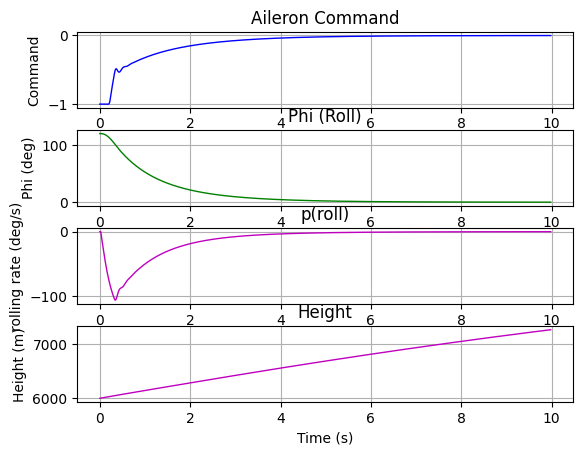

In [2]:
# 只调试滚转角控制器，通过控制副翼快速稳定俯仰角

from abc import ABC
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import os
from math import *
from typing import Literal
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import sys
import os
# import matplotlib
# matplotlib.use('Qt5Agg')
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
import socket
import threading
import time
import jsbsim
import matplotlib.pyplot as plt
import math
import numpy as np
from simple_pid import PID
from numpy.linalg import norm



class DeltaPID(object):
    """增量式PID算法实现"""
    def __init__(self, p=0, i=0, d=0) -> None:
        self.k_p = p  # 比例系数
        self.k_i = i  # 积分系数
        self.k_d = d  # 微分系数
        self._pre_error = 0  # t-1 时刻误差值
        self._pre_pre_error = 0  # t-2 时刻误差值
    def calculate(self, error, dt=0.02):
        p_change = self.k_p * (error - self._pre_error)
        i_change = self.k_i * error * dt
        d_change = self.k_d * (error - 2 * self._pre_error + self._pre_pre_error) / dt
        delta_output = p_change + i_change + d_change  # 本次增量
        self._pre_pre_error = self._pre_error
        self._pre_error = error
        return delta_output

def active_rotation(vector, heading, theta, gamma):
    # vector是行向量，根据psi，theta，gamma的顺序旋转坐标系，最后输出行向量
    # 注意：北天东坐标
    psi = - heading
    R1 = np.array([
        [cos(psi), 0, sin(psi)],
        [0, 1, 0],
        [-sin(psi), 0, cos(psi)]
    ])
    R2 = np.array([
        [cos(theta), -sin(theta), 0],
        [sin(theta), cos(theta), 0],
        [0, 0, 1]
    ])
    R3 = np.array([
        [1, 0, 0],
        [0, cos(gamma), -sin(gamma)],
        [0, sin(gamma), cos(gamma)]
    ])
    return vector @ R1.T @ R2.T @ R3.T

def sub_of_radian(input1, input2):
    # 计算两个弧度的差值，范围为[-pi, pi]
    diff = input1 - input2
    diff = (diff + pi) % (2 * pi) - pi
    return diff


dt = 0.02  # 0.02

tacview_show=0

if tacview_show:
    print('please prepare tacview')
    # sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    from visualize.tacview_visualize import Tacview

    tacview = Tacview()

# 启动 JSBSim
sim = jsbsim.FGFDMExec(None, None)
sim.set_debug_level(0)
sim.set_dt(dt)  # 解算步长 dt 秒

# 设置模型路径（一般 JSBSim pip 包自动包含）
sim.load_model("f16")  # f15, p51d, ball 等模型可选

a_pid = DeltaPID(p=0/pi, i=240/pi, d=0/pi) # 滚转控制器调参

# 初始姿态与目标滚转角
# 连续输出并tacview中可视化
start_time = time.time()
target_phi = 0
t_last = 10

# 设置初始状态（单位：英尺、节、角度）
sim["ic/h-sl-ft"] = 6000 * 3.2808  # 高度：m -> ft
sim["ic/vt-kts"] = 300 * 1.9438  # 空速： m/s-> 节
sim["ic/psi-true-deg"] = 0  # 航向角: °
sim["ic/phi-deg"] = 120
sim["ic/theta-deg"] = 30
sim["ic/alpha-deg"] = 0
sim["ic/beta-deg"] = 0
sim["ic/long-gc-deg"] = -118  # 设置初始经度（单位：度）
sim["ic/lat-gc-deg"] = 34  # 设置初始纬度（单位：度）

# 初始化状态
sim.run_ic()
sim.set_property_value('propulsion/set-running', -1)

phis = []

thrust_data = []  # 添加推力数据记录
time_steps = []

# 记录控制量
aileron_cmd = []
elevator_cmd = []
rudder_cmd = []
throttle_cmd = []
heights=[]
a_last=0
ps=[]

# hist_act=np.array([0,0,0,1])
for step in range(int(t_last / dt)):
    sim.run()
    current_time = step * dt
    time_steps.append(current_time)
    
    # 取姿态角度
    phi = sim["attitude/phi-deg"]      # 滚转角 (roll)
    
    # 角速度
    p = sim["velocities/p-rad_sec"]  # 横滚角速度（弧度/秒）
    q = sim["velocities/q-rad_sec"]  # 俯仰角速度（弧度/秒）
    r = sim["velocities/r-rad_sec"]  # 偏航角速度（弧度/秒）
    
    phi_error_deg = target_phi-phi
    phi_error = phi_error_deg*pi/180

    aileron = phi_error_deg/180*3 - p/pi * 2

    # aileron = a_last + a_pid.calculate(phi_error, dt=dt)

    sim["fcs/aileron-cmd-norm"]=np.clip(aileron, -1, 1)
    

    sim["fcs/elevator-cmd-norm"]=0
    sim["fcs/rudder-cmd-norm"]=0
    sim["fcs/throttle-cmd-norm"] = 0.7

    # # 记录控制量
    aileron_cmd.append(sim["fcs/aileron-cmd-norm"])

    phis.append(phi)
    heights.append(sim["position/h-sl-ft"] * 0.3048)
    ps.append(p*180/pi)
    
    # 通过tacview可视化
    if tacview_show and step % np.round(1 / dt) == 0:
        send_t = f"{current_time:.2f}"
        name_R = '001'
        loc_r = [float(lon), float(lat), float(alt)]
        # data_to_send = f"#{send_t:.2f}\n{name_R},T={loc_r[0]:.6f}|{loc_r[1]:.6f}|{loc_r[2]:.6f},Name=F16,Color=Red\n"
        data_to_send = "#%.2f\n%s,T=%.6f|%.6f|%.6f|%.6f|%.6f|%.6f,Name=F16,Color=Red\n" % (
        float(send_t), name_R, loc_r[0], loc_r[1], loc_r[2], phi, theta, psi)
        tacview.send_data_to_client(data_to_send)
        # time.sleep(0.001)

    mach = sim["velocities/mach"]
    # # 可以记录或打印
    # print(f"Time: {current_time:.1f}s, Mach: {mach:.3f}")
end_time = time.time()
print(f"程序运行时间: {end_time - start_time:.2f} 秒")

# aileron_cmd  elevator_cmd  rudder_cmd   throttle_cmd

# 绘制控制命令曲线
fig, axs = plt.subplots(4, 1)

time_steps = np.array(range(len(aileron_cmd)))*dt

# 调整子图布局
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 副翼控制命令
axs[0].plot(time_steps, aileron_cmd, 'b-', linewidth=1)
axs[0].set_title('Aileron Command')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Command')
axs[0].grid(True)

axs[1].plot(time_steps, phis, 'g-', linewidth=1)
axs[1].set_title('Phi (Roll)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Phi (deg)')
axs[1].grid(True)

axs[2].plot(time_steps, ps, 'm-', linewidth=1)
axs[2].set_title('p(roll)')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('rolling rate (deg/s)')
axs[2].grid(True)

axs[3].plot(time_steps, heights, 'm-', linewidth=1)
axs[3].set_title('Height')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Height (m)')
axs[3].grid(True)

# fig2.set_size_inches(1280/91, 720/91)

# plt.show(block=False)  # 姿态与状态窗口非阻塞显示

plt.show()

# input("按回车键关闭所有窗口...")  # 保持窗口，直到你手动关闭



### 高速大角度俯冲时候的副翼控制有发散趋势，不过暂时不管